In [1]:
from itertools import product
from scipy import stats
from scipy.special import gamma, hyp2f1
from astropy import units as u
from astropy.cosmology import LambdaCDM
from astropy.constants import L_sun, c
import matplotlib as mpl
from astropy import units as u
from astropy.cosmology import LambdaCDM
from scipy.integrate import quad
mpl.use('pdf')
import seaborn as sns
cosmo = LambdaCDM(H0=70, Om0=0.3, 
                  Ode0=0.7)

In [2]:
cosmo1 = LambdaCDM(H0=100, Om0=0.3, Ode0=0.7)
cosmo2 = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
cosmo3 = LambdaCDM(H0=67.66, Om0=0.3111, Ode0=0.6889, Tcmb0=2.725, Ob0=0.02242/(0.6766) ** 2)
Zs = np.linspace(0, 1.1117, 1000)
dV1 = np.array([((cosmo1.differential_comoving_volume(z) * \
                  (17046 * u.deg**2).to(u.sr) / ((c/cosmo1.H0)**3).to(u.Mpc**3)).value) for z in Zs])
dV2 = np.array([((cosmo2.differential_comoving_volume(z) * \
                  (17046 * u.deg**2).to(u.sr) / ((c/cosmo2.H0)**3).to(u.Mpc**3)).value) for z in Zs])
dV3 = np.array([((cosmo3.differential_comoving_volume(z) * \
                  (17046 * u.deg**2).to(u.sr) / ((c/cosmo3.H0)**3).to(u.Mpc**3)).value) for z in Zs])
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.plot(Zs, dV1, color='red', label='H0=100')
ax.plot(Zs, dV2*dV1.max()/dV2.max(), color='blue', label='H0=70')
ax.plot(Zs, dV3*dV1.max()/dV3.max(), color='green', label='H0=67.66')
ax.legend()
fig.savefig('dVdZ(z).pdf')

In [3]:
D_H_V = (((c/cosmo.H0)**3).to(u.Mpc**3)).value
A = hyp2f1(1/3, 1/2, 4/3, -3/7)
B = 17046 *(np.pi/180)**2
def p(L, z):
    Phi = L ** alpha * np.exp(-L) / gamma(alpha + 1)
    return Phi * dVdz(z)
def my_dVdz(z):
    param = 1+z
    return B * 10/7 * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) ** 2 / np.sqrt(3/10 *param **3 + 7/10)
Zs = np.linspace(0, 1.1117, 1000)
dV = [((cosmo.differential_comoving_volume(z) * (17046 * u.deg**2).to(u.sr) / ((c/cosmo.H0)**3).to(u.Mpc**3)).value) for z in Zs]

fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.plot(Zs, dV)
ax.plot(Zs, my_dVdz(Zs),color='red', linestyle='--')
fig.savefig('dVdZ(z).pdf')

In [4]:
L0 = L_sun.to(u.erg/u.s).value
alpha, L_star = -7.83280781e-02,  5.27617193e+09 * L0
dVdz_max = my_dVdz(1.11172022586983898)

def sample_z():
    while True:
        z = np.random.uniform([0, 0], [1.11172022586983898, dVdz_max])
        if z[1] <= my_dVdz(z[0]):
            return z[0]
dist = stats.gamma(alpha + 1)
def my_sample():
    return (dist.rvs(), sample_z())

In [5]:
%%timeit
[my_sample() for i in range(10000)]

941 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
sample = np.array([my_sample() for i in range(10000000)])

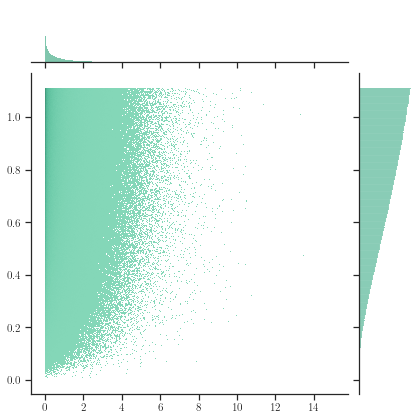

In [8]:
%matplotlib inline
sns.set_theme(style="ticks")
img = sns.jointplot(x = sample[:, 0], y = sample[:, 1], color="#4CB391", kind='hist')

In [7]:
len(sample)

10000000

In [8]:
L0 = L_sun.to(u.erg/u.s).value
D_H_in_10pc = ((c/cosmo.H0).to(u.pc)/(10 * u.pc)).value
A = hyp2f1(1/3, 1/2, 4/3, -3/7)
B = 17046 *(np.pi/180)**2
def mis(L, z):
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    if 4.54 - 2.5 * np.log10(L/L0) \
    + 5 * np.log10(D_L) \
    + 2.6 * z + 4.3 * z ** 2 < 17.5:
        return True
    else:
        return False

In [9]:
sample1 = sample
sample1[:, 0] = sample1[:, 0] * L_star
selected_sample = np.array([s for s in sample1 if mis(*s)])
log_sample = np.log10(selected_sample[:, 0])

In [10]:
len(selected_sample)

3589

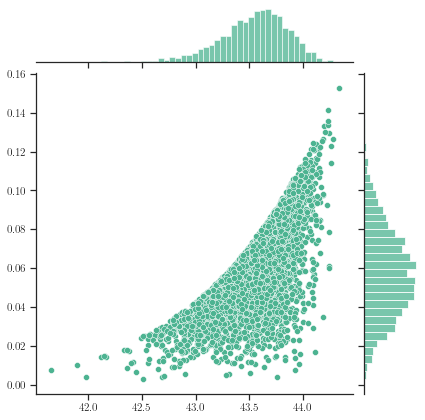

In [12]:
%matplotlib inline
sns.set_theme(style="ticks")
img = sns.jointplot(x = np.log10(selected_sample)[:, 0], y = selected_sample[:, 1],
                    color="#4CB391", kind='scatter')

In [13]:
Data = pd.read_csv('results27_14_8_55_72.csv', index_col='specid')
Data = Data[(Data['bmag'] > 0)  & (Data['z_helio']>0)]
Data.columns = [idx.replace('_', ' ') for idx in Data.columns]

def Mb(bmag, z):
    K = 2.6 * z + 4.3 * z ** 2
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    mu = 5 * np.log10(D_L)
    return bmag - mu - K
Data['Mb'] = list(map(Mb, *Data[['bmag', 'z helio']].values.T))
Data['L rel to sun'] = Data['Mb'].map(lambda Mb: 10 ** ((Mb- 4.54)/(-2.5)) * L0)
Data.loc[:, 'dVdz'] = Data['z helio'].map(my_dVdz)

In [14]:
Data['log L'] = Data['L rel to sun'].map(np.log10)

In [15]:
data = Data[(Data['bmag'] < 17.5) & (Data['z helio'] < 1.11172022586983898) & (Data['dVdz']>0)]

In [16]:
data.loc[:, 'log L'] = data['L rel to sun'].map(np.log10)

C:\Users\ASUS\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


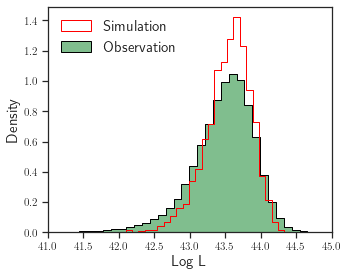

In [17]:
data.loc[:, 'log L'] = data['L rel to sun'].map(np.log10)

fig, ax = plt.subplots(1, 1, figsize=(5,4))
img = sns.histplot(log_sample, ax=ax,stat='density',bins=30,alpha=0, 
                   label='Simulation',element='step',ec='red')
sns.histplot(data['log L'], ax = ax, bins=100, stat='density', zorder=-10, color='C2',label='Observation',
         element='step',ec='black')
img.set_xlabel("Log L", fontdict={'fontsize':15})
img.set_ylabel("Density", fontdict={'fontsize':15})
ax.legend(frameon=False,loc=2,fontsize=15)
ax.set_xlim([41, 45])
plt.tight_layout()

In [214]:
fig.savefig('result(b is less than 17.5).pdf')

In [32]:
L_max(0.01)

4.782679531323492e+41

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = contour_func(
C:\Users\ASUS\AppData\Local\Temp/ipykernel_1424/3049902353.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 ** ((4.54 - 17.5 + 5 * np.log10(D_L) \
C:\Users\ASUS\AppData\Local\Temp/ipykernel_1424/3049902353.py:15: RuntimeWarning: divide by zero encountered in log10
  img.ax_joint.fill_betweenx(Zs, np.log10(L_max(Zs)), hatch="//", fc='none', ec="black", label="$\\mathbf{b_j>17.5}$")


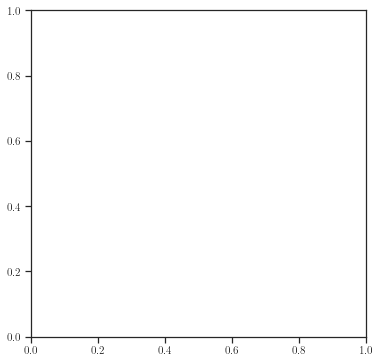

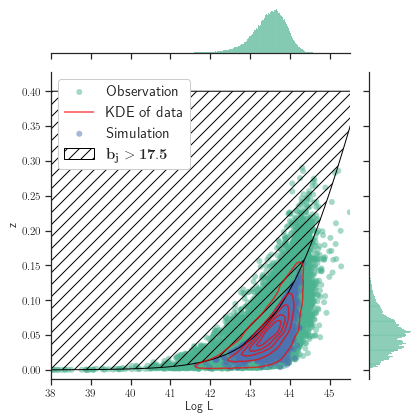

In [45]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(6, 6));
sns.set_theme(style="ticks")
img = sns.jointplot(x = Data['log L'].values, y = Data['z helio'].values,
            color="#4CB391", kind='scatter', alpha=0.5,ec='none', label='Observation')
img.plot_joint(sns.kdeplot, color="red", zorder=20, linestyle='--', alpha=0.7,levels=6,label="KDE of data")
sns.scatterplot(x = np.log10(selected_sample)[:, 0], y = selected_sample[:, 1],ec='none',
                color="C0", alpha=.5, ax=img.ax_joint, label="Simulation")
def L_max(z):
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    return 10 ** ((4.54 - 17.5 + 5 * np.log10(D_L) \
    + 2.6 * z + 4.3 * z ** 2)/2.5) * L0
Zs = np.linspace(0, 0.4, 10000)
img.ax_joint.fill_betweenx(Zs, np.log10(L_max(Zs)), hatch="//", fc='none', ec="black", label="$\\mathbf{b_j>17.5}$")
img.ax_joint.set_xlim([38, 45.5])
img.ax_joint.legend(loc="upper left", fontsize=15, framealpha=1)
img.ax_joint.set_xlabel("Log L")
img.ax_joint.set_ylabel("z")
plt.tight_layout()

In [47]:
img.savefig("Observation and Simulation.pdf")

In [48]:
L_star

2.019718614804e+43

In [186]:
img.savefig('Observation VS Simulation(b less than 17.5).pdf')

C:\Users\ASUS\AppData\Local\Temp/ipykernel_11608/223083767.py:9: RuntimeWarning: divide by zero encountered in log10
  return 10 ** ((5.31 - 19 + 5 * np.log10(D_L) \
C:\Users\ASUS\AppData\Local\Temp/ipykernel_11608/223083767.py:11: RuntimeWarning: divide by zero encountered in log10
  img.ax_joint.plot(np.log10(L_max(Zs)), Zs)


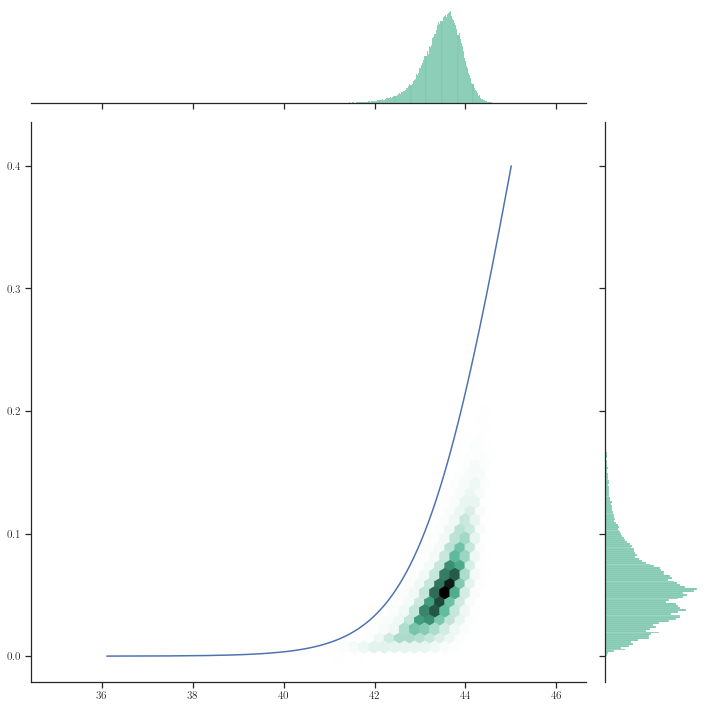

In [67]:
%matplotlib inline
sns.set_theme(style="ticks")
img = sns.jointplot(x=Data['log L'].values, y=Data['z helio'].values,
                    color="#4CB391", kind='scatter',height=10)
Zs = np.linspace(0, 0.4, 10000)
def L_max(z):
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    return 10 ** ((4.54 - 19 + 5 * np.log10(D_L) \
    + 2.6 * z + 4.3 * z ** 2)/2.5) * L0
img.ax_joint.plot(np.log10(L_max(Zs)), Zs)

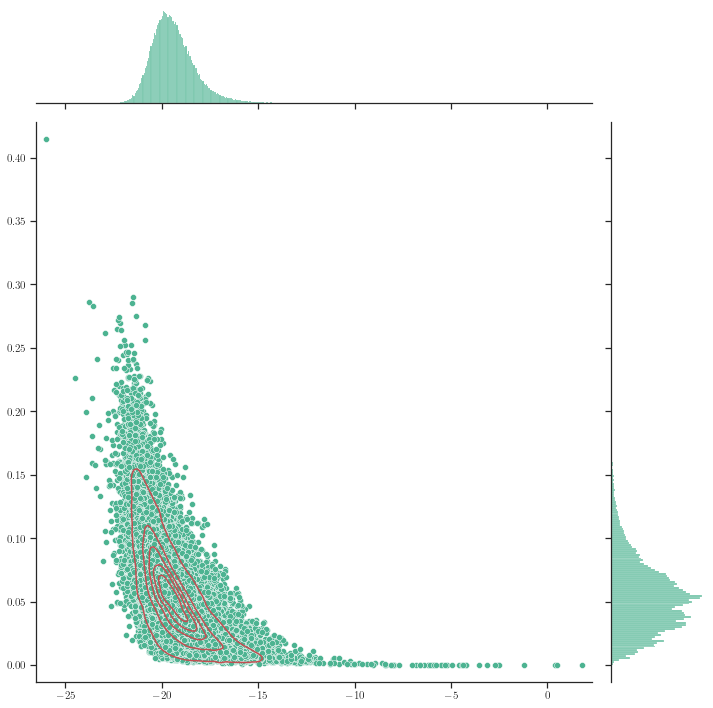

In [14]:
%matplotlib inline
sns.set_theme(style="ticks")
img = sns.jointplot(x=Data['Mb'].values, y=Data['z helio'].values,
                    color="#4CB391", kind='scatter',height=10)
img.plot_joint(sns.kdeplot, color="C0", zorder=10, levels=6)

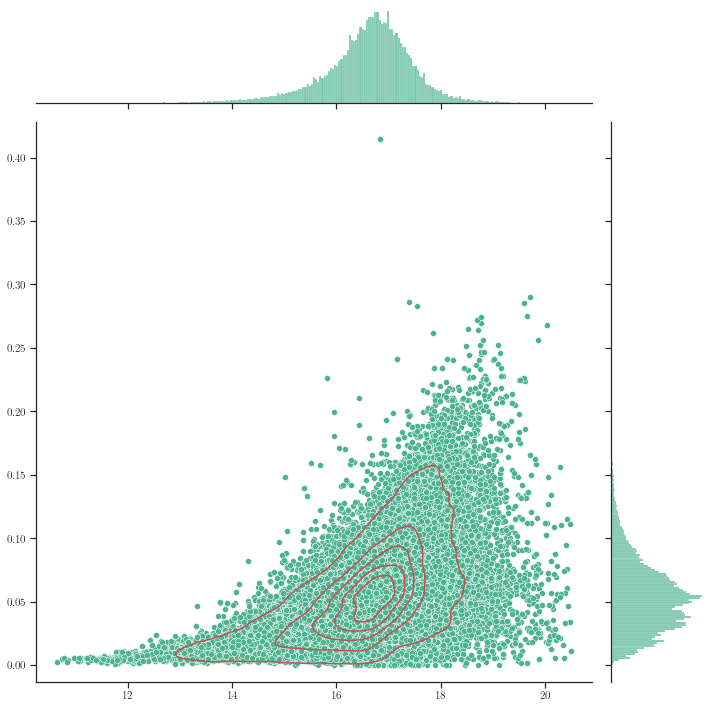

In [21]:
%matplotlib inline
sns.set_theme(style="ticks")
img = sns.jointplot(x=Data['bmag'].values, y=Data['z helio'].values,
                    color="#4CB391", kind='scatter',height=10)
img.plot_joint(sns.kdeplot, color="r", zorder=10, levels=6)

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp/ipykernel_24560/1334609143.py:10: RuntimeWarning: divide by zero encountered in log10
  return 10 ** ((4.54 - 17.5 + 5 * np.log10(D_L) \
C:\Users\ASUS\AppData\Local\Temp/ipykernel_24560/1334609143.py:12: RuntimeWarning: divide by zero encountered in log10
  img.ax_joint.plot(np.log10(L_max(Zs)), Zs, color='orange', linewidth=2)


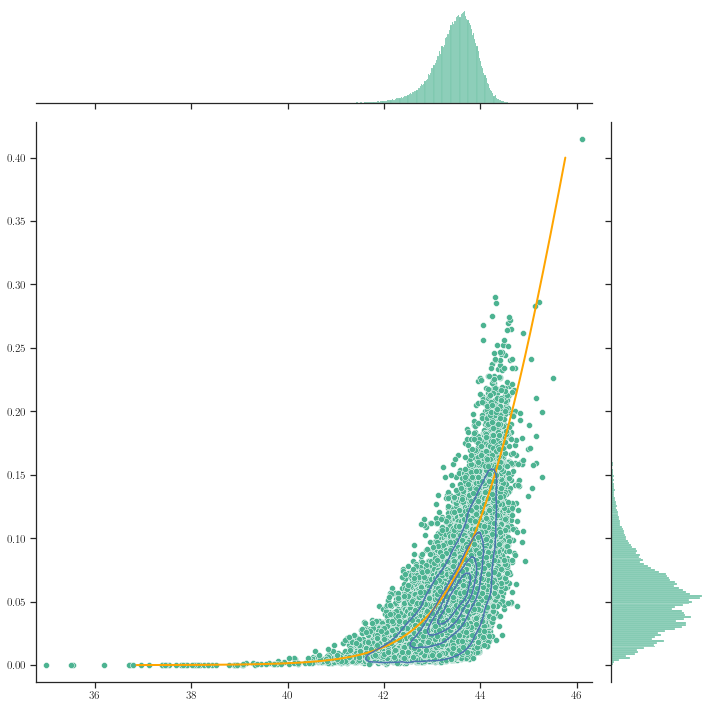

In [13]:
%matplotlib inline
sns.set_theme(style="ticks")
img = sns.jointplot(Data['log L'].values,Data['z helio'].values,
                    color="#4CB391", kind='scatter',height=10)
img.plot_joint(sns.kdeplot, color="C0", zorder=10, levels=5)
Zs = np.linspace(0, 0.4, 10000)
def L_max(z):
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    return 10 ** ((4.54 - 17.5 + 5 * np.log10(D_L) \
    + 2.6 * z + 4.3 * z ** 2)/2.5) * L0
img.ax_joint.plot(np.log10(L_max(Zs)), Zs, color='orange', linewidth=2)

In [234]:
img.savefig("choose b.jpeg",dpi=500)

In [16]:

Zs = np.linspace(0, 0.4, 10000)
def L_max(z):
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    return 10 ** ((4.54 - 17 + 5 * np.log10(D_L) \
    + 2.6 * z + 4.3 * z ** 2)/2.5) * L0
img.ax_joint.plot(np.log10(L_max(Zs)), Zs)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_11796/4102215340.py:5: RuntimeWarning: divide by zero encountered in log10
  return 10 ** ((5.31 - 17 + 5 * np.log10(D_L) \
C:\Users\ASUS\AppData\Local\Temp/ipykernel_11796/4102215340.py:7: RuntimeWarning: divide by zero encountered in log10
  img.ax_joint.plot(np.log10(L_max(Zs)), Zs)


In [17]:
img

In [90]:
D_H_in_10pc = ((c/cosmo.H0).to(u.pc)/(10 * u.pc)).value
def Mb(bmag, z):
    K = 2.6 * z + 4.3 * z ** 2
    param = 1 + z
    D_L = param * np.sqrt(10/7) * (param * hyp2f1(1/3, 1/2, 4/3, -3/7 * param **3) - A) * D_H_in_10pc
    mu = 5 * np.log10(D_L)
    return bmag - mu - K

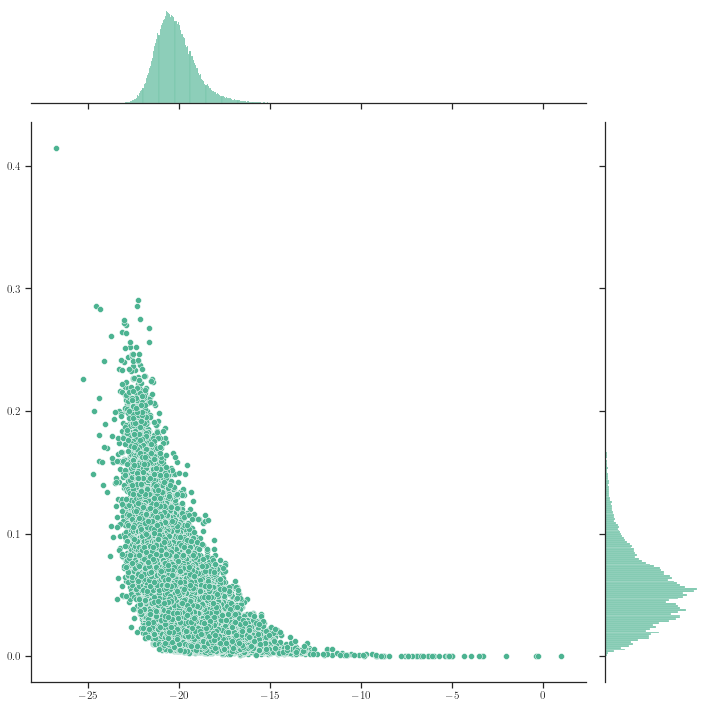

In [22]:
%matplotlib inline
sns.set_theme(style="ticks")
img = sns.jointplot(x=Data['Mb'].values, y=Data['z helio'].values,
                    color="#4CB391", kind='scatter',height=10)
#img.plot_joint(sns.kdeplot, color="r", zorder=10, levels=6)

In [26]:
plt.fill_betweenx?